<div class="alert alert-success">
<h2>Extract total amount TTC of receipts</h2>
<br><br>    
After reading this paper: https://arxiv.org/pdf/1903.12363.pdf
<br><br>
I've thought about a way to implement the preprocessing of images receipts described in the article. 
This notebook recaps my code proposal for the preprocessing of receipts before feeding the CNN/NLP/NER algorithm.
<br><br>    

I've used an open-sorce dataset available at the link below:
    The link of receipts datasets (200): https://expressexpense.com/blog/free-receipt-images-ocr-machine-learning-dataset/

</div>

In [10]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = (
    r"d:\Java\Tesseract\tesseract.exe"
)
# This Notebook is going to make use of pytesseract which is a wrapper for Google tesseract OCR

import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import random
import cv2
from PIL import Image
from glob import glob

In [11]:
# Get all file names 
receipt_files = glob('./large-receipt-image-dataset-SRD/*')
receipt_files[:3]

['./large-receipt-image-dataset-SRD\\1000-receipt.jpg',
 './large-receipt-image-dataset-SRD\\1001-receipt.jpg',
 './large-receipt-image-dataset-SRD\\1002-receipt.jpg']

# Overview of the dataset 

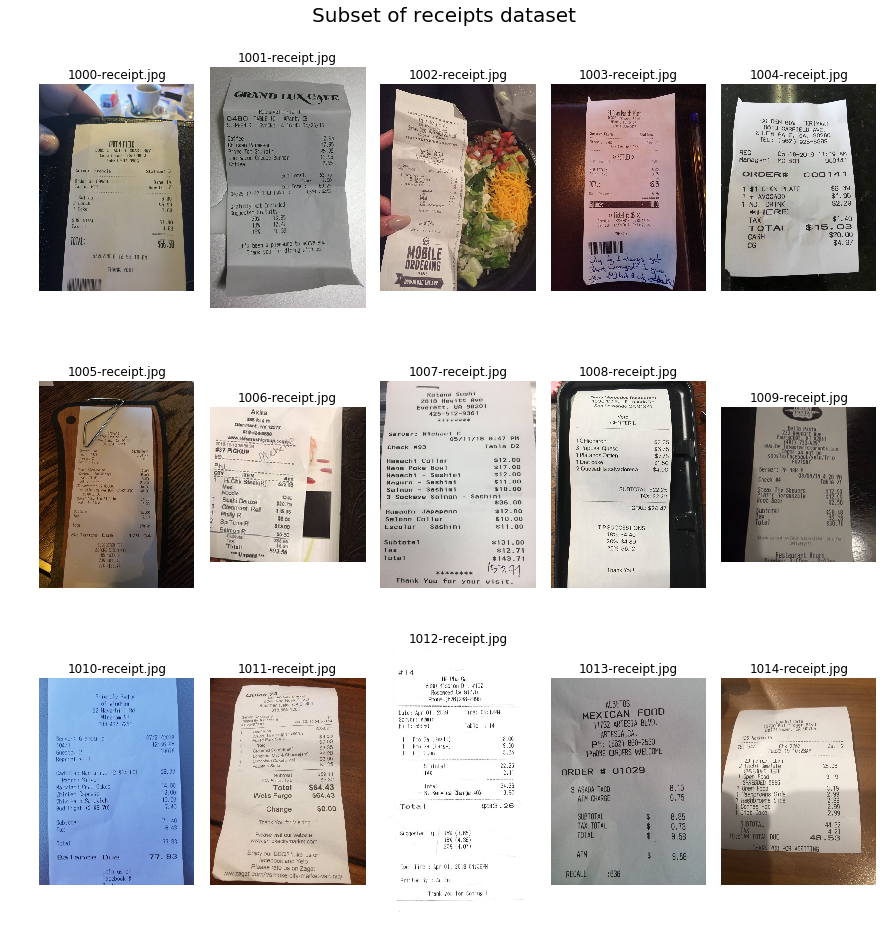

In [14]:
fig = plt.figure(figsize=(15,15))
size1, size2 = 3 ,5
plt.suptitle( 'Subset of receipts dataset' , fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.95, wspace=0.1, hspace=0)
ind = 1
for i in range(size1):
    for j in range(size2):
        plt.subplot(size1,size2,ind)
        path = receipt_files[ind-1]
        ind += 1
        image = Image.open(path)#skimage.io.imread(path)
        plt.imshow(image)#.astype(np.uint8))
        plt.title(path.split('\\')[-1])
        plt.axis('off')
plt.show()

<div class="alert alert-success">
    The first thing we can note is that the task is going to be tricky at some point. The 1002 receipt for example, the receipt has been pictured but is not centered on the image. The light is not uniformed: see receipt 1005 compared to receipt 1012...
</div>

#  Tesseract OCR 

<div class="alert alert-success">
Quoting https://arxiv.org/pdf/1903.12363.pdf: <br>

"To generate input grid data for the convolutional neural network, the scanned document image are processed
by an OCR engine to acquire the texts and their absolute relative positions."
<br><br>
The first step is to get the grid that will then feed the CNN with. 
</div>

    
  
  
  

GREEN FIELD
5305 E PACIFIC COAST HWY
Long Beach, CA 90804
(562) 597-0906

Server: Francis Station: 3

Order #: 69923

Dine In

Table: B11 Guests: 2

1 Coffee 3.00

2 Lunch 45.90
1 Coke 3.00
SUB TOTAL: 51.90
Tax 1: U.68

TOTAL: $56.50

5/26/2016 12:53:10 PM

INAH

THANK YOU!



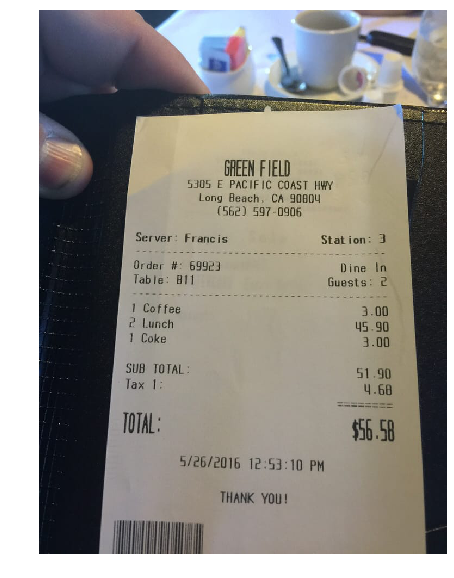

In [15]:
receipt_0 = Image.open(receipt_files[0])
print(pytesseract.image_to_string(receipt_0))
plt.figure(figsize=(10,10))
plt.imshow(receipt_0)
plt.axis('off')
plt.show()

<div class="alert alert-success">
    We can see that most of the text was extracted without any preprocessing of the image. Still, there are few errors.</div>

In [16]:
#  get characters and correspongding position
ocr_out = pytesseract.image_to_boxes(receipt_0)

#  plot position of each character detectedon the image
img = cv2.imread(receipt_files[0])
h, w, _ = img.shape
for bbox in ocr_out.split('\n'):
    split = bbox.split(' ')
    text = split[0]
    point1 = (int(split[1]), h - int(split[2]))
    point2 = (int(split[3]), h -int(split[4]))
    img = cv2.rectangle(img,point1,point2,(255,0,0),2)
    
plt.figure(figsize=(8,10))
plt.imshow(img)
plt.axis('off')

IndexError: list index out of range

<div class="alert alert-success">
    Tesseract OCR is also able to locate the character on the image. The total amount was not accurately read: It detected only one character whereas there are two digits after the comma. We'll deal with this issue in the following.
<br><br>
There are some big rectangles that doesn't seem to correspond to any character. These detections are going to be removed in the following.
</div>

In [17]:
fig = plt.figure(figsize=(15,10))

plt.tight_layout()
plt.subplots_adjust(top=0.95, wspace=0.1, hspace=0)

points = []
for bbox in ocr_out.split('\n'):
    split = bbox.split(' ')
    text = split[0]
    point1 = (int(split[3]) + int(split[1])) / 2
    point2 =  (h -  int(split[4]) + h - int(split[2]))/2
    points.append([point1,point2])

img = cv2.imread(receipt_files[0])
white = np.zeros((h,w))
for point in points:
    x = int(point[0])
    y = int(point[1])
    img = cv2.circle(img, (x,y) , 3, (255,0,0))
    white = cv2.circle(white, (x,y) , 5, (255,255,255), 6)

plt.subplot(1,2,1)
#plt.title()
plt.imshow(img)
plt.axis('off')    

plt.subplot(1,2,2)
plt.imshow(white)
plt.axis('off')

plt.show()

IndexError: list index out of range

<Figure size 1080x720 with 0 Axes>

<div class="alert alert-success">
    On the right, you'll find the position of each character found by Tesseract OCR. The location of a single character is not useful. On the right we can see that character belonging to the same word or paragraph are closed. This kind of problem can be tackled with clustering algorithms. 
   <br> <br> The following tries to gather points that correspond to characters belonging to the same word. </div>

In [18]:
clustering = DBSCAN(eps=27, min_samples=2).fit_predict(points)

<div class="alert alert-success">
    One way to gather points is to use clustering algorithms. I chose DBSCAN because one don't have to precise the number of cluster and it deals well with outliers. In our case we can see above that we have several outsiders and that it would be nice to remove them. <br><br> Only <b>eps</b> parameter need to be set which is the minimal distance between two points to be considered as neighbor and then belong to the same cluster.
<br><br>
The value of 27 appears to work well on this image after several tries.</div>

In [19]:
# Just for nice plotting: get a color for each cluster 
dico_color = {}
for i in range(np.max(clustering)+1):
    dico_color[i] = (random.randint(0,255),random.randint(0,255),random.randint(0,255))

In [20]:
# Plot clusters
plt.figure(figsize=(12,16))
img = cv2.imread(receipt_files[0])
h, w, _ = img.shape

# plot a rectangle around each character with the color of the cluster
for en,bbox in enumerate(ocr_out.split('\n')):
    split = bbox.split(' ')
    text = split[0]
    bottom_left = (int(split[1]), h - int(split[2]))
    top_right = (int(split[3]), h -  int(split[4]))
    if clustering[en] != -1:
        img = cv2.rectangle(img, bottom_left, top_right, dico_color[clustering[en]], 2)

plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')

#  plot a rectangle around each cluster 
img = cv2.imread(receipt_files[0])
dico_area_location = {} #  store location of each cluster for the following
for i in range(np.max(clustering)+1):
    wh = np.where(clustering==i) #  select points from cluster i
    arr = np.array(ocr_out.split('\n'))[wh]
    LX,LY = [], []
    for en,bbox in enumerate(arr):
        split = bbox.split(' ')       
        LX.append(int(split[1]))
        LX.append(int(split[3]))   
        LY.append( h - int(split[2]))
        LY.append( h - int(split[4]))
    bottom_left = (min(LX)-5,min(LY)-5) # among every character in the cluster, take min(x), min(y)
    top_right = (max(LX)+5,max(LY)+5) # among every character in the cluster, take max(x), max(y)
    dico_area_location[i] = [bottom_left, top_right]

    img = cv2.rectangle(img, bottom_left, top_right, dico_color[i], 2) # draw a rectangle containing 
    #  every character in the cluster  

plt.subplot(1,2,2)
plt.imshow(img)
plt.axis('off')
plt.show()

IndexError: list index out of range

<Figure size 864x1152 with 0 Axes>

<div class="alert alert-success">
    This last plot is very interesting because the different area with text are highlighted. We can now extract for each cluster, the text that it contains:</div>

In [21]:
img = cv2.imread(receipt_files[0]) 
to_pop_list = []

for cluster in dico_area_location:
    [bottom_left, top_right] = dico_area_location[cluster]
    pad = 4 #  add some pixels around cluster area
    img_crop = img[ bottom_left[1] - pad :top_right[1] + pad, bottom_left[0] - pad:top_right[0] + pad , :]
    # The cropped image can have weird shape and tesseract OCR is more accurate if we transform the cropped image as followed
    img_crop = cv2.resize(img_crop, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC) 
    img_crop = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
    # Run tesseract on the cropped image
    text = pytesseract.image_to_string(img_crop)
    if text != '': 
        print('Cluster {}'.format(cluster))
        plt.figure(figsize=(5,5))
        plt.imshow(img_crop)
        plt.axis('off')
        plt.show()
        print('text extracted: ', text)
        print()
        dico_area_location[cluster].append(text)
    else:
        to_pop_list.append(cluster)
        
# Remove area without text        
for i in to_pop_list:
    dico_area_location.pop(i)

# Ensure no key is skipped due to removal
dico_area_location_copy = {}
for en, key in enumerate(dico_area_location):
    dico_area_location_copy[en] = dico_area_location[key]
dico_area_location = dico_area_location_copy 

NameError: name 'dico_area_location' is not defined

In [22]:
dico_area_location

NameError: name 'dico_area_location' is not defined

<div class="alert alert-success">
    The dictionnary displayed above shows that we have for each cluster, its location and the text it contains.</div>

In [23]:
# Get the center of each cluster
middle_points = []
for cluster in dico_area_location:
    rect = dico_area_location[cluster][:2]
    middle_points.append([np.mean([rect[0][0],rect[1][0]]),np.mean([rect[0][1],rect[1][1]])])
middle_points

NameError: name 'dico_area_location' is not defined

<div class="alert alert-success">
   Apply clustering one more time to split cluster in grid: Looking only at the y position, apply clustering to get a mapping like: cluster 0 belong to line 1, cluster 0 and 2 belongs to line 2 ...
<br><br>One more time Dbscan allows not to choose the number of line/columns. </div>

In [24]:
x_axis = list(np.array(middle_points).T[0])
y_axis = list(np.array(middle_points).T[1])
zeros = list(np.zeros(np.array(middle_points).T[0].shape))
x_for_clustering = np.array([x_axis,zeros]).T
y_for_clustering = np.array([zeros,y_axis]).T

IndexError: index 0 is out of bounds for axis 0 with size 0

In [25]:
clustering_x = DBSCAN(eps=40, min_samples=1).fit_predict(x_for_clustering)
clustering_y = DBSCAN(eps=40, min_samples=1).fit_predict(y_for_clustering)

NameError: name 'x_for_clustering' is not defined

<div class="alert alert-success">
     The value of 40 for <b>eps</b> was set thanks to a few trials. This value should depends on the size of the picture. <br> <br>Note that <b>min_samples</b> is now 1 instead of 2 because, here we don't have outlier anymore and we want each point to be asssigned to a cluster even if it's alone.</div>

In [26]:
nb_line = len(set(clustering_y))
nb_columns = len(set(clustering_x))

NameError: name 'clustering_y' is not defined

In [27]:
def sort_cluster(clustering, axis):
    """
    args:
        - clustering: array (output of clustering on the axis)
        - axis : x_axix or y_axis defined above.
    Returns:
        - a mapping dictionnary. The objective is to sort cluster number with respect to their x or y average value
    """
    L_means = []
    for num_cluster in range(max(clustering)+1):
        wh_cluster = np.where(clustering == num_cluster)
        L_points = []
        for index in wh_cluster[0]:
            point = axis[index]
            L_points.append(point)
        mean = np.mean(np.array(L_points))
        L_means.append(mean)
    sorted_args = np.argsort(L_means)
    mapping_cluster = {}
    for en, cluster_num in enumerate(sorted_args):
        mapping_cluster[en] = cluster_num
    
    return mapping_cluster

mapping_cluster = sort_cluster(clustering_x, x_axis)    

NameError: name 'clustering_x' is not defined

<div class="alert alert-success">
    Build a table_data to feed matplotlib.table function and draw the table just like in the PDF https://arxiv.org/pdf/1903.12363.pdf.</div>

In [17]:
table_data = []
for num_cluster_y in range(max(clustering_y)):
    wh_cluster_y = np.where(clustering_y == num_cluster_y)
    line = [' ' for i in range(nb_columns)]
    for index in wh_cluster_y[0]:
        num_cluster_x = clustering_x[index]
        num_cluster_x = mapping_cluster[num_cluster_x]
        text = dico_area_location[int(index)][2]
        line[int(num_cluster_x)] = text
    table_data.append(line)
table_data        

[[' ', 'GREEN FIELD', ' '],
 [' ', '5305 E PACIFIC COAST HWY\nLong Beach, CA 90804\n(562) 597-0906', ' '],
 ['Server: Francis', ' ', 'Station: 3'],
 ['Order #: 69923\nTable: BI1', ' ', 'Dine In\nGuests: 2'],
 ['| Coffee\ne Lunch\n1 Coke', ' ', '3.00\n45.90\n3.00'],
 ['Tax 1:', ' ', '51.90\n4.68'],
 ['TOTAL:', ' ', '$56.48'],
 [' ', '4/26/2016 12:53:10 PM', ' ']]

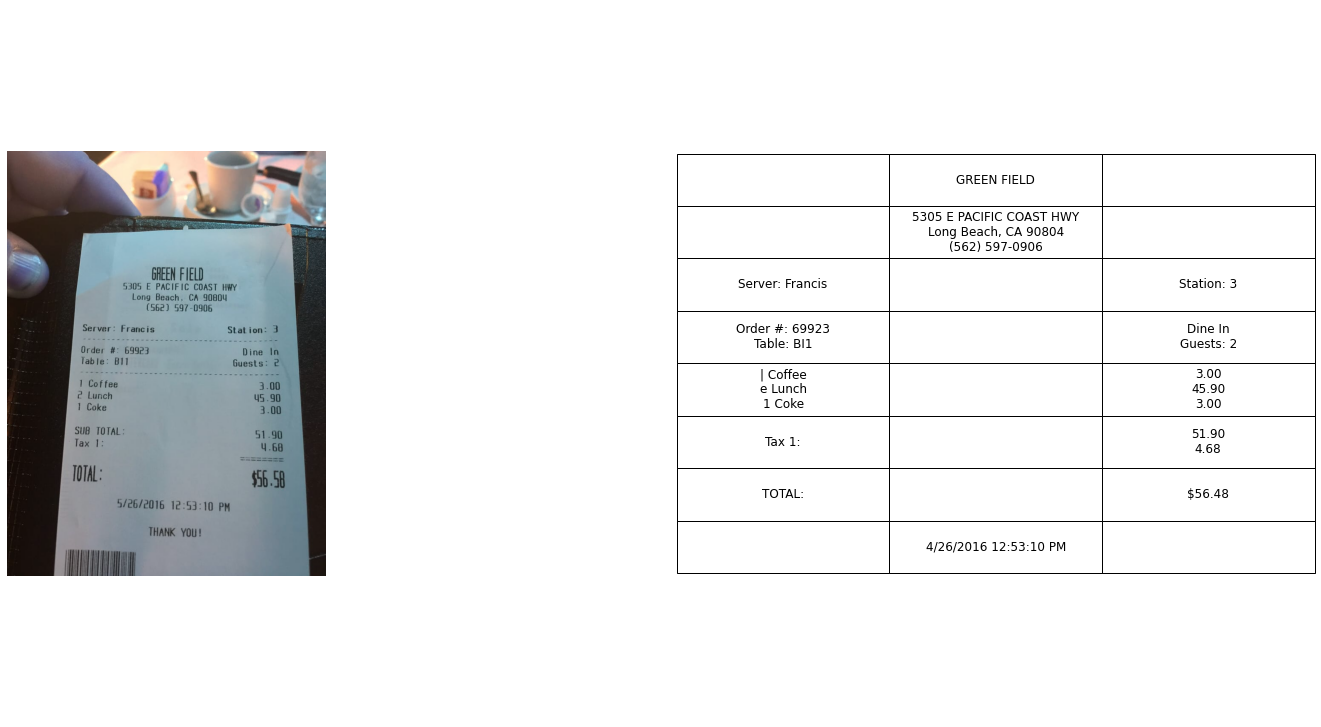

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12,12))

axes[0].imshow(img)
axes[0].axis("off")  

table = axes[1].table(cellText=table_data, loc='right', cellLoc='center')
table.set_fontsize(44)
table.scale(2,4)
axes[1].axis("off")  

#plt.tight_layout()
plt.subplots_adjust(top=0.95, wspace=0.1, hspace=0)
plt.show()

<div class="alert alert-success">
    Finally the output is the plot on the right and on the left you can see the  input image. It can be seen that the spatial position of each character in the input image has been respected. That's to say 'GREEN FIELD' was at the top, in the center in the image, In the table it is also at the top and center.
<br> <br> An advantage of using DbScan clustering is that the number of rows and lines are set automatically and for this image, 3 columns appears to be a reasonable choice.
<br> <br>
Unfortunately, this type of processing doesn't appear to generalize well. Indeed, when running the same code on the other receipts, most of them were not correctly extracted and rendered. It is very likely to be due to the eps parameters used in DBScan. If it is not set well, it will gathers characters that shouldn't be as it is the minimal distance between two neighbors. It would be cool to try setting it according to the shape of the image etc.
<br> <br>
The following step is to run a CNN on the output grid we got from last part.
<br> <br>
I didn't find any pre-trained CNN for this task. The labels for the dataset given weren't available so it is not possible to train an algorithm. The 200 receipts would be enough to reach accurate results according to the article.
<br> <br>
The first step is to encode words and then to run a CNN
</div>